# Predicting Program Languages

For this project our group will be scraping, and using api requests to acquire repository data from Github and attempt to create an NLP model to predict the primary programming language of the repo based off the contents of the readme file.

## Goals:

* Scrape repo names from Github, and use api requests to create a database of repos
* Explore data to see what words are most common in each respective language's readmes
* Build a classification model that predicts program languages used in each repo on Github

---

## Imports

In [1]:
# Import function modules
import prepare as p
import acquire as a
import explore as e


# Import data science libraries & visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import nlp libraries and classification models
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package wordnet to /Users/goat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/goat/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


---

## Dictionary

| Column         | Column_type | Data_type| Description              |
|----------------|-------------|----------|--------------------------|
|repo            |Feature      |string    |Name of the repositiory.  |
|language        |Target       |string    |Programming language used.|
|readme_contents |Feature      |string    |Contents for every readme.|

---

## Acquire

For data acquisition, the names of 100 pages worth of 'sports' repositories (1000 repos) were scraped using html requests. Then using api requests information such as language, name, and readme contents, was pulled from the repositories. This process was slow due to request limits so the data was cached into a csv once done.

In [2]:
pd.read_csv('all_repos.csv').head(3)  # Read data stored in .csv file

,repo,language,readme_contents
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN..."
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...


---

## Wrangle

For data cleaning, any language that wasn't in the top 4 was grouped into 'other'. The extra number of languages severy impacted model performance, so grouping them was helpful. The data was also cleaned, stemmed, and lemmatized.

In [3]:
repo = a.acquire_repos()  # Pull and clean data stored in .csv file
repo.head(3)

,repo,language,readme_contents,clean,stemmed,lemmatized,readme_length,unique_word
0,ScottfreeLLC/AlphaPy,Python,AlphaPy\n=======\n\n|badge_pypi| |badge_downlo...,alphapy badgepypi badgedownloads badgedocs bad...,alphapi badgepypi badgedownload badgedoc badge...,alphapy badgepypi badgedownloads badgedocs bad...,3158,33
1,jalapic/engsoccerdata,R,"Latest GitHub version: 11/4/2022, v0.1.7\n\nN...",latest github version 1142022 v017 nov 2022 up...,latest github version 1142022 v017 nov 2022 up...,latest github version 1142022 v017 nov 2022 up...,20310,38
2,bttmly/nba,JavaScript,# nba\n*Node.js client for nba.com API endpoin...,nba nodejs client nbacom api endpoints npm ins...,nba nodej client nbacom api endpoint npm insta...,nba nodejs client nbacom api endpoint npm inst...,6963,37


During the wrangling process, around 200 rows were dropped due to incorrect language (jupyter notebook), and missing data. 

---

## Exploration

Before beggining exploration the data is split into train, val, test so that only the train data is explored on.

In [4]:
train, val, test = p.train_val_test(repo, 'language', stratify=True)  # Splits data and stratifies by target variable

(557, 8) (120, 8) (120, 8)


Then, a dataframe of the total number of time each word appeared in each language is created.

In [5]:
# Use function to create a dataframe with the word counts of each word
repo = p.word_counts(train, 'language', 'clean')
repo.head(3)

,all,Other,R,Python,JavaScript,TypeScript
data,1105,276,144,461,109,115
barry,808,0,0,758,50,0
1,743,277,71,241,133,21


We will also calculate in how many documents each word appeared in.

In [6]:
e.get_words(train)

(['tool',
  'tool',
  'display',
  'activity',
  'tool',
  'tool',
  'use',
  'new',
  'activity',
  'create',
  'activity',
  'feature',
  'option',
  'full',
  'list',
  'feature',
  'note',
  'tool',
  'pip',
  'window',
  'user',
  'package',
  'also',
  'activity',
  'see',
  'installation',
  'page',
  'information',
  'using',
  'create',
  'new',
  'using',
  'command',
  'install',
  'using',
  'pip',
  'install',
  'using',
  'create',
  'new',
  'using',
  'command',
  'create',
  'api',
  'tool',
  'need',
  'api',
  'create',
  'new',
  'set',
  'field',
  'id',
  'first',
  'run',
  'tool',
  'open',
  'window',
  'page',
  'activity',
  'note',
  'tool',
  'activity',
  'page',
  'code',
  'tool',
  'api',
  'code',
  'tool',
  'get',
  'need',
  'need',
  'want',
  'tool',
  'way',
  'example',
  'tool',
  'activity',
  'set',
  'activity',
  'type',
  'time',
  'activity',
  'information',
  'create',
  'new',
  'project',
  'page',
  'create',
  'new',
  'name',
  'al

In [7]:
python_freq, javascript_freq, r_freq, typescript_freq, other_freq, all_freq = e.freq(train)

### What are the most common words in READMEs?

In [8]:
e.count_prop(train)

,n,percent
file,843,0.592664
barry,796,0.559621
sport,645,0.453462
run,602,0.423231
use,582,0.409170
...,...,...
root,51,0.035855
language,51,0.035855
contributing,51,0.035855
2020,51,0.035855


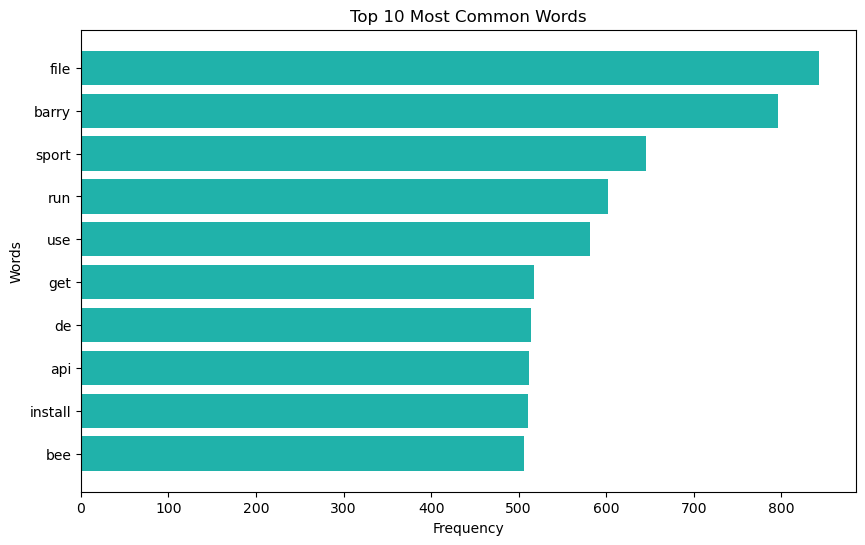

In [9]:
e.top_10_words(train)

### Does the length of the README vary by programming language?

H0: There is no significant difference between README lengths for Python and R.
    
Ha: There is a significant difference between README lengths for Python and R.

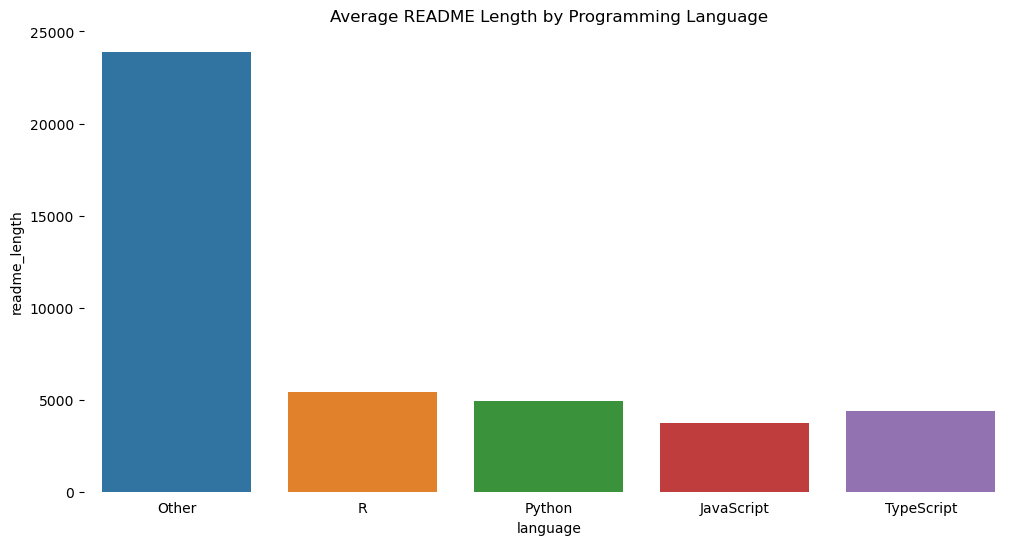

In [10]:
e.plt_average_length(train)

In [11]:
e.test1(train)

t = -0.24015086531852026
p = 0.8104722066719134
Fail to reject the null hypothesis. There is no significant difference between README lengths for Python and R.


### Do different programming languages use a different number of unique words?

H0: There is not an association between programming languages and unique word counts.

Ha: There is an association between programming languages and unique word counts.

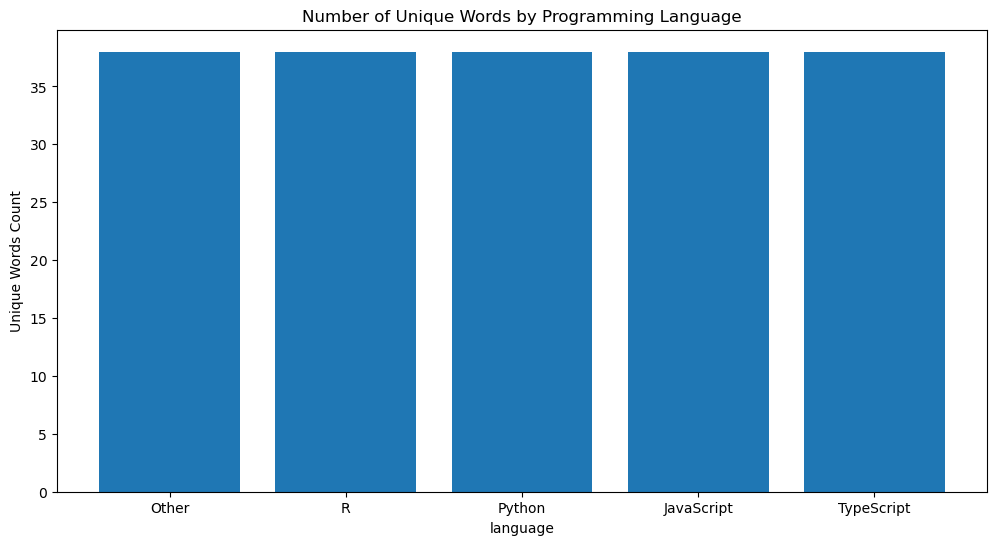

In [12]:
e.plt_unique_words(train)

In [13]:
e.test2(train)

Chi2 = 143.3770269989248
P = 0.11247907101319876
Fail to reject the null hypothesis. There is no significant association.


### Are there any words that uniquely identify a programming language?

In [14]:
total_appearances = p.word_appearances(repo, trrain)  # Calculate the number of separate readmes that a word appeared in
word_counts['total_appearances'] = total_appearances

NameError: name 'trrain' is not defined

### EDA Summary

---

## Modeling

Now we will create some models to try to predict the primary language of a repo based off the readme contents

In [ ]:
# Create dataframe again
repo = pd.read_csv('all_repos.csv')
repo.language = p.top_languages(repo, 4)

### Baseline

The first mode created is the baseline.

In [ ]:
# Calculate baseline from the mode of the languages
baseline = pd.DataFrame(train.language)
baseline['baseline'] = baseline.language.value_counts().index[0]
print(f'Baseline accuracy: {round((baseline.language == baseline.baseline).sum()/(len(baseline)),2)}')

Baseline model only guesses 'other' since it is the most common 'language'. The baseline accuracy is only 43%!

### Pre-Processing

Using the word counts per language, a filter is created to eliminate words that appear very few times.

In [ ]:
repo2 = p.cleanse(repo, 'readme_contents')
all_words = p.word_counts(repo2, 'language', 'clean')  # Use word counts to create filter
word_filter = list(all_words[all_words['all'] < 35].index)  # Create list to remove all words that appear less than 35 times total

In [ ]:
repo = p.cleanse(repo, 'readme_contents', extra_words=word_filter)  # Clean data
train, val, test = p.train_val_test(repo, 'language', stratify=True, print_shape=False)
X_train_tfidf, y_train, X_val_tfidf, y_val, X_test_tfidf, y_test = p.preprocess(train, val, test)

Before modeling data is split into x and y and each word is turned into a feature so the models can properly use data.

### XGBRegressor

XGB was the third best model. It is extremelly overfit.

In [ ]:
# Create label ecoder and encode tager variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.fit_transform(y_val)

# Create and train model object
xgb = XGBClassifier()
xgb.fit(X_train_tfidf, y_train_encoded)

In [ ]:
# Score model
p.test_model(xgb, X_train_tfidf, y_train_encoded)
p.test_model(xgb, X_val_tfidf, y_val_encoded)

### Linear Regression

Linear regression performed the second best and it was less overfit.

In [ ]:
# Create and train model object
lm = LogisticRegression(class_weight='balanced')
lm.fit(X_train_tfidf, y_train)

In [ ]:
# Score model
p.test_model(lm, X_train_tfidf, y_train)
p.test_model(lm, X_val_tfidf, y_val)

### Random Forest Classifier

The best model was random forest classifier

In [ ]:
rfc = RandomForestClassifier(random_state=42)  # Create model object
rfc.fit(X_train_tfidf, y_train)  # Fit model

In [ ]:
# Score model
p.test_model(rfc, X_train_tfidf, y_train)
p.test_model(rfc, X_val_tfidf, y_val)
p.test_model(rfc, X_test_tfidf, y_test)

Random forest classifier was very overfit and validated at 67% accuracy and tested at 63% accuracy.

---

# Conclusion

---

# Recomendations

---

# Next Steps

---